In [142]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
import matplotlib.pyplot as plt

In [187]:
def interpolador(subject, method, size):
    data = np.array([int(line.strip()) for line in subject.to_numpy()])
    x = np.arange(len(data))
    x_new = np.linspace(0, len(data) - 1, size)
    x_new = np.unique(np.concatenate((x, x_new)))  
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    if method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    return data_interp

In [169]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(y,window_size):
    window_size = window_size
    threshold_high = 2.3
    threshold_low = -2.3

    transition_point = None

    # Desplazar la ventana a lo largo del array
    for i in range(len(y) - window_size):
        window = y[i:i + window_size]
        
        # Verificar si hay valores por arriba de 2.5 o por abajo de -2.5
        if not np.any(window >= threshold_high) and not np.any(window <= threshold_low):
            transition_point = i
            break
        else:
            continue 

    return transition_point

In [212]:
def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        transition_point1 = arm_detector(ff1, 500)
        transition_point2 = arm_detector(ff2, 500)
        if transition_point2 is not None:
            ff2 = ff2[:transition_point2]
        elif transition_point2 is None:
            transition_point2 = len(ff2)
        if transition_point1 is not None and transition_point1 < transition_point2:
            ff1 = ff1[:transition_point1]
        else:
            ff1 = ff1[:transition_point2]

    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [191]:
#dataframe datos de compositores 

datos_composers = {}
carpeta = r'Sequences\labels'
archivos_en_carpeta = os.listdir(carpeta)
print(archivos_en_carpeta)
index0 = 0
indice = 0

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa, header = None)
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    datos_composers[composer] = {} #genero bibio para composer
    datos_composers[composer]['Birth_year'] = archivo.split('-')[0] #año de nacimiento
    index1 = serie.iloc[0, 0].split('\t')[0] #el # del primer serie del composer
    index2 = int(serie.iloc[len(serie)-3, 0].split('\t')[0]) - index0 # # Piezas
    index0 = index2 + index0 # numero total de piezas anteriores
    datos_composers[composer]['# Piezas'] = index2 # Piezas
    datos_composers[composer]['Indice'] = indice
    indice += 1

datos_composers_df = pd.DataFrame(datos_composers)
print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])
print(datos_composers_df)    

['1397-dufay-Labels.txt', '1500-morales-Labels.txt', '1521-desprez-Labels.txt', '1525-palestrina-Labels.txt', '1532-lasso-Labels.txt', '1538-byrd-Labels.txt', '1548-victoria-Labels.txt', '1557-gabrielis-Labels.txt', '1563-dowland-Labels.txt', '1566-gesualdo-Labels.txt', '1567-monteverdi-Labels.txt', '1583-frescobaldi-Labels.txt', '1587-scheidt-Labels.txt', '1616-froberger-Labels.txt', '1629-anglebert-Labels.txt', '1632-lully-Labels.txt', '1637-buxtehude-Labels.txt', '1653-pachelbel-Labels.txt', '1668-couperin-Labels.txt', '1671-albinoni-Labels.txt', '1678-vivaldi-Labels.txt', '1681-telemann-Labels.txt', '1682-dandrieu-Labels.txt', '1683-rameau-Labels.txt', '1685-handel-Labels.txt', '1685-scarlatti-Labels.txt', '1688-zipoli-Labels.txt', '1721-bach-js-Labels.txt', '1732-haydn-Labels.txt', '1736-albrechtsberger-Labels.txt', '1752-clementi-Labels.txt', '1756-mozart-Labels.txt', '1770-beethoven-Labels.txt', '1771-cramer-Labels.txt', '1782-paganini-Labels.txt', '1797-schubert-Labels.txt', '1

C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_9408\1761750877.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])


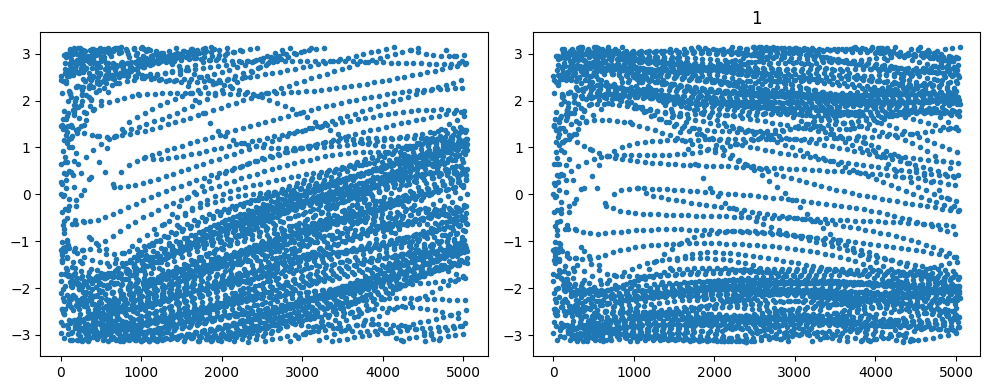

5047 5047
5047 5047
0.982927313455848


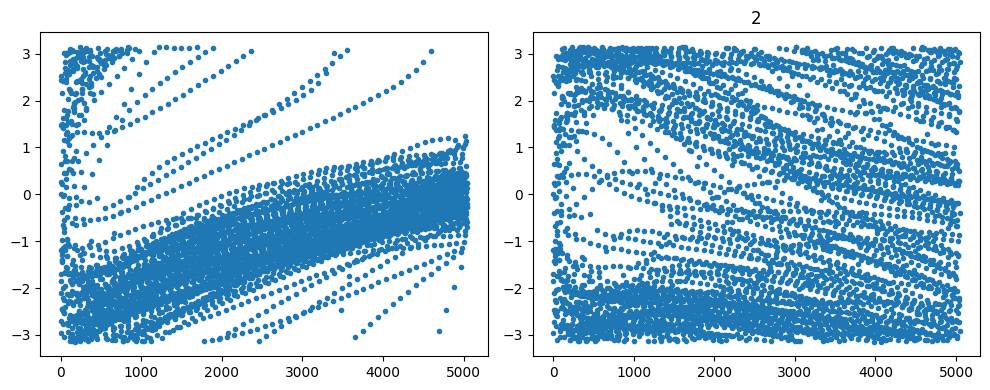

5046 5046
5046 5046
0.9429994483343157


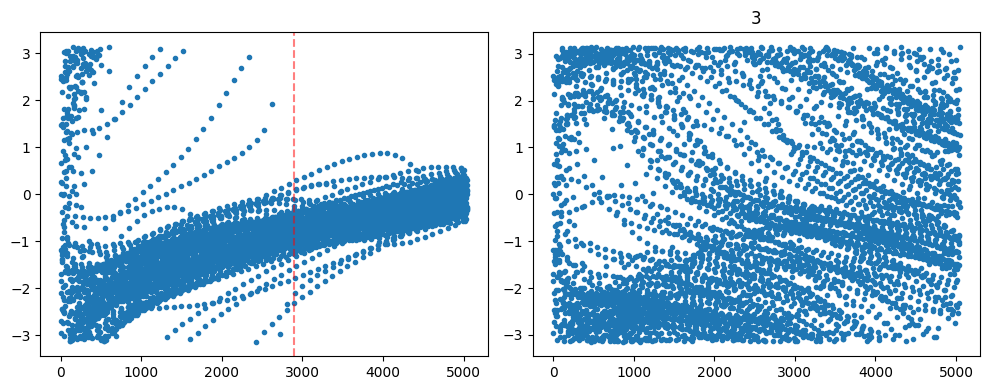

5046 5046
2902 5046
0.9543342177585644


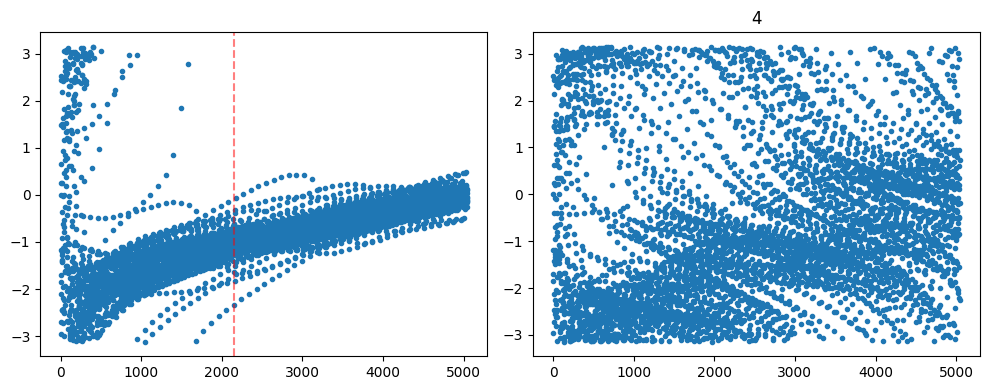

5045 5045
2150 5045
0.8523104146322369


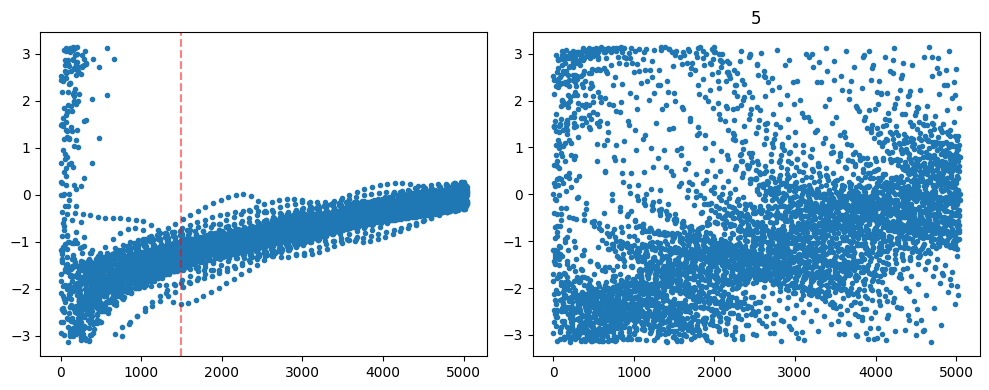

5045 5045
1492 5045
0.8163912362126345


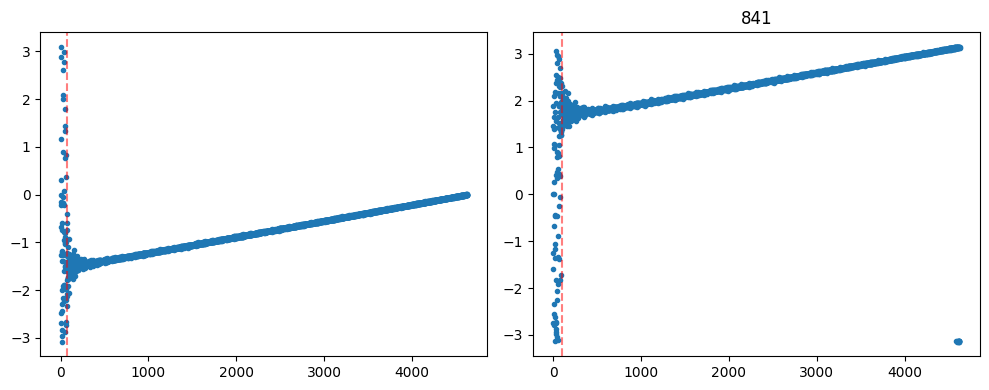

4627 4627
74 103
0.9264877726923417


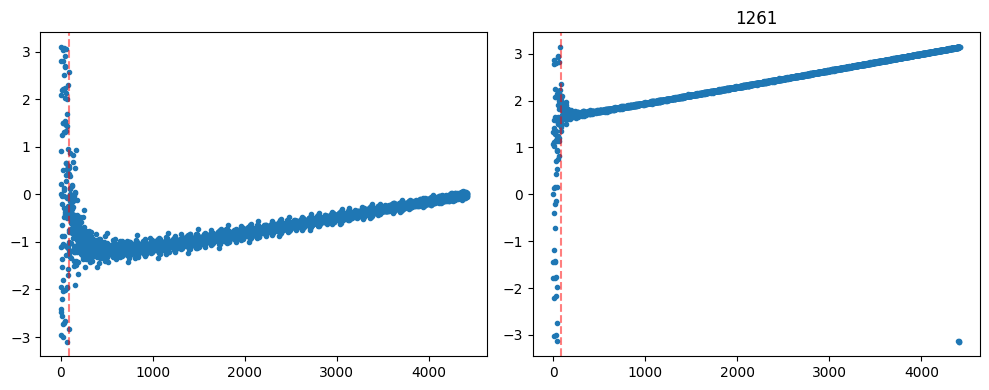

4417 4417
91 91
0.8672768114199343


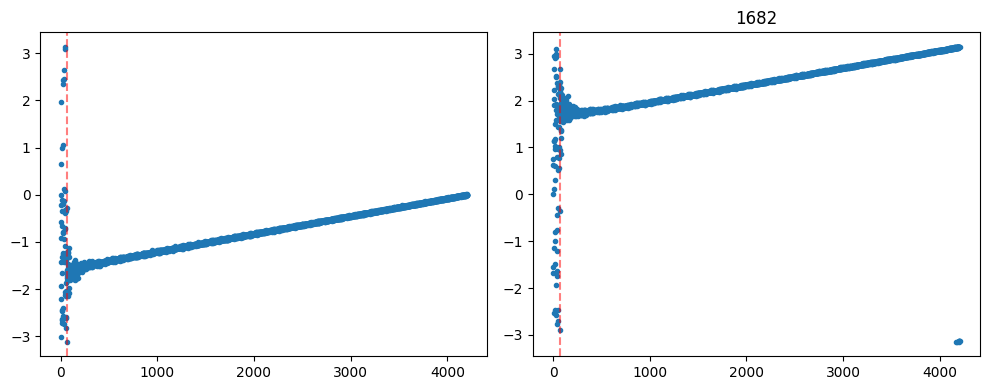

4206 4206
66 73
0.9990033644424372


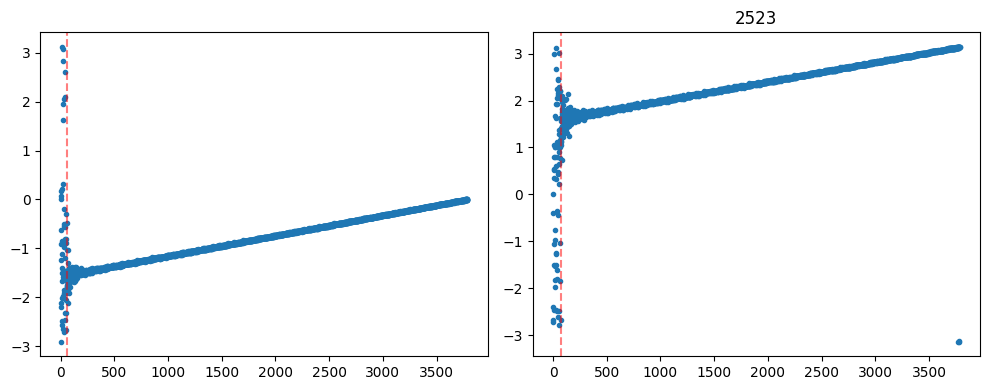

3786 3786
56 78
0.8129950576287173


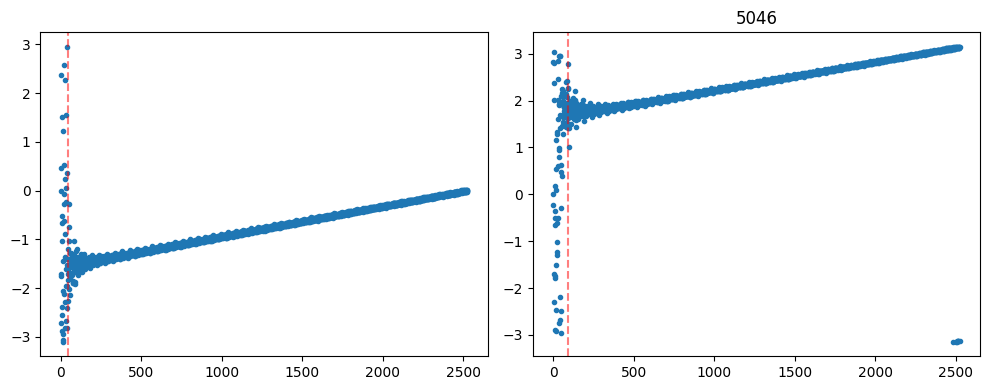

2524 2524
44 91
0.9305508394255797


In [210]:
subject = composers['Morales']['Serie_25']
interp = interpolador(subject,'herm', 10000)
for tamaño in [1,2,3,4,5,len(interp)//12,len(interp)//8,len(interp)//6,len(interp)//4, len(interp)//2]:
    ff1 = np.angle(np.fft.rfft(interp[tamaño:]))
    ff2 = np.angle(np.fft.rfft(interp[:-tamaño]))
    transition_point1 = arm_detector(ff1, 500)
    transition_point2 = arm_detector(ff2, 500)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plt.title(tamaño)
    ax[0].plot(ff1, '.')
    if transition_point1 is not None:
        ax[0].axvline(x=transition_point1, color='red', linestyle='--', alpha=0.5)
    ax[1].plot(ff2, '.')
    if transition_point2 is not None:
        ax[1].axvline(x=transition_point2, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    J = J_univariante(interp, tamaño, True)
    print(J)

In [189]:
composers = {}
M = 0
carpeta = r'Sequences\Series'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa)
    # escoge una serie
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    composers[composer] = {}

    for pieza in range( datos_composers[composer]['# Piezas'] ):
        N = serie.iloc[0, 0].split('\t')[1] # # de elementos por pieza
        M = int(N) + M
        index_n1 = 0 
        index_n2 = int(N)+2 
        serie_n = serie[index_n1 + 2:index_n2].reset_index(drop=True) # resetear index
        serie = serie[index_n2 +1:] # recortar serie Original
        serie_n.index += 1 # que index empiece desde 1
        num_serie_T = serie.columns[0]  # numero de serie de todo el dataset
        num_serie = pieza + 1
        composers[composer]['Serie_'+str(num_serie)] = serie_n.squeeze() # agregamos pieza al dicc composer con key como # serie
print('Número total de elementos de todo el dataset: ', M)

['1397-dufay-Series.txt', '1500-morales-Series.txt', '1521-desprez-Series.txt', '1525-palestrina-Series.txt', '1532-lasso-Series.txt', '1538-byrd-Series.txt', '1548-victoria-Series.txt', '1557-gabrielis-Series.txt', '1563-dowland-Series.txt', '1566-gesualdo-Series.txt', '1567-monteverdi-Series.txt', '1583-frescobaldi-Series.txt', '1587-scheidt-Series.txt', '1616-froberger-Series.txt', '1629-anglebert-Series.txt', '1632-lully-Series.txt', '1637-buxtehude-Series.txt', '1653-pachelbel-Series.txt', '1668-couperin-Series.txt', '1671-albinoni-Series.txt', '1678-vivaldi-Series.txt', '1681-telemann-Series.txt', '1682-dandrieu-Series.txt', '1683-rameau-Series.txt', '1685-handel-Series.txt', '1685-scarlatti-Series.txt', '1688-zipoli-Series.txt', '1721-bach-js-Series.txt', '1732-haydn-Series.txt', '1736-albrechtsberger-Series.txt', '1752-clementi-Series.txt', '1756-mozart-Series.txt', '1770-beethoven-Series.txt', '1771-cramer-Series.txt', '1782-paganini-Series.txt', '1797-schubert-Series.txt', '1

In [154]:
# Js = np.full((77,2160), np.nan)
# for x, composer in enumerate(composers):
#     for y, serie in enumerate(composers[composer]):
#         f = composers[composer][serie]
#         Js[x,y] = J_univariante(f, int(len(f)/2), len(f))
#     print(composer)
# np.save('J_composers.npy', Js)
"""Se calculó la J para cada compositor de cada serie inalterada en el numpy array Js  como J_composers.npy"""

In [25]:
# Ns = np.full((77,2160), np.nan)
# for x, composer in enumerate(composers):
#     for y, serie in enumerate(composers[composer]):
#         Ns[x,y] = len(composers[composer][serie])
# np.save('Ns.npy', Ns)

"""Se guardó la el tamaño de cada serie en Ns.npy"""

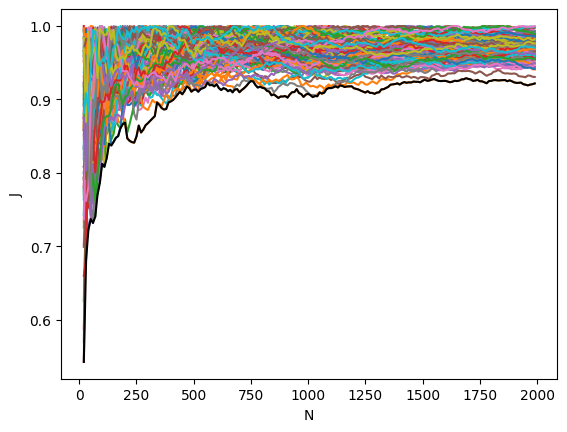

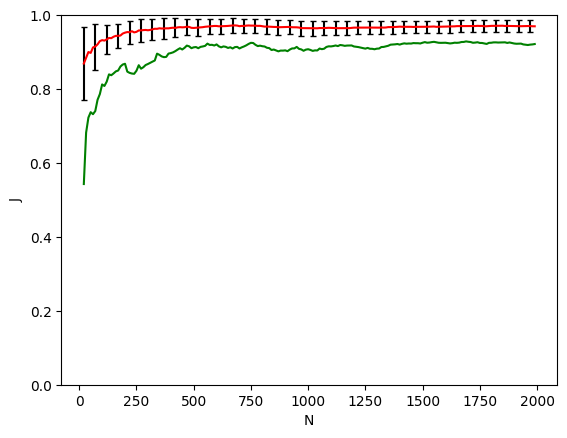

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

Ns = np.load('Ns.npy')
Js = np.load('J_composers.npy')
Jotas = np.load('Jotas.npy') #Jotas.npy contiene los 100 vectores de J hipotesis nula

x = range(20, 2000, 10)
J_mean = np.mean(Jotas, axis=0)
J_std = np.std(Jotas, axis = 0)

J_minus = np.min(Jotas, axis=0)

for i in range(100):
    plt.plot(x, Jotas[i,:])
plt.plot(x, J_minus, 'black')
plt.xlabel('N')
plt.ylabel('J')
plt.show()
fig, ax = plt.subplots()
ax.errorbar(x = x[::5], y = J_mean[::5], yerr= J_std[::5], fmt='none', ecolor = 'black', capsize=2)
ax.plot(x, J_mean, color = 'red')

ax.set_ylim(0, 1)
ax.set_xlabel('N')
ax.set_ylabel('J') 
# plt.scatter(len(canon), canon_j, marker ='.', color = 'green')
ax.plot(x, J_minus, 'green')
# plt.plot(Ns[0,:], Js[0,:], '.',color = 'blue')
with open('j_null.pkl', 'wb') as f:
    pickle.dump(fig, f)
plt.show()

In [156]:
"""Aquí se graficó J v N para compositor"""
# import matplotlib.pyplot as plt
# import numpy as np

# Ns = np.load('Ns.npy')
# Js = np.load('J_composers.npy')
# Jotas = np.load('Jotas.npy')

# x = range(20, 2000, 10)
# J_mean = np.mean(Jotas, axis=0)
# J_std = np.std(Jotas, axis = 0)

# J_minus = np.min(Jotas, axis=0)

# print('A graficar')
# # Create a figure and subplots
# fig, axs = plt.subplots(40, 2, figsize=(13, 210))

# # Adjust spacing between subplots
# fig.subplots_adjust(hspace=0.4, wspace=0.2)

# # Flatten the axs array to iterate over the subplots
# axs = axs.flatten()

# # Plot data on each subplot
# for i,composer in enumerate(composers):
#         #Siempre
#     axs[i].errorbar(x = x[::5], y = J_mean[::5], yerr= J_std[::5], fmt='none', ecolor = 'black', capsize=2)
#     axs[i].plot(x, J_mean, color = 'red')
#     axs[i].set_ylim(0.5, 1)
#     axs[i].set_xlim(0, 2000)
#     axs[i].set_xlabel('N')
#     axs[i].set_ylabel('J') 
#     axs[i].plot(x, J_minus, 'green')
#     axs[i].grid()
#     #for in
#     axs[i].set_title(composer)
#     axs[i].plot(Ns[i,:], Js[i,:], '.',color = 'blue')

# # Hide any empty subplots
# for j in range(76, 80):
#     axs[j].axis('off')

# plt.show()


In [157]:
"""Boxplots de los J de datos inalterados"""
# import numpy as np
# import matplotlib.pyplot as plt


# Js = np.load('J_composers.npy')
# Ns = np.load('Ns.npy')
# data = [Js[i,:datos_composers[composer]['# Piezas']] for i, composer in enumerate(datos_composers.keys())]


# fig, ax = plt.subplots(figsize=(20, 10))
# ax.boxplot(data, patch_artist=True)


# ax.set_xlabel('Compositor')
# ax.set_ylabel('J index')
# ax.set_xticks(np.arange(1, 78))  
# ax.set_xticklabels([f'{composer}' for i, composer in enumerate(datos_composers.keys())], rotation=90)  # Rotar las etiquetas del eje x

# ax.xaxis.set_label_position('top')  # Movemos la etiqueta del eje x
# ax.xaxis.tick_top()  # Movemos los ticks del eje x a la parte superior
# ax.spines['top'].set_position(('axes', 1.0))  # Movemos la espina superior al tope de la figura
# ax.spines['bottom'].set_position(('axes', -0.1))  # Ocultamos la espina inferior

# plt.setp(ax.get_xticklabels(), rotation=90, ha='center')


# plt.tight_layout()


# plt.show()

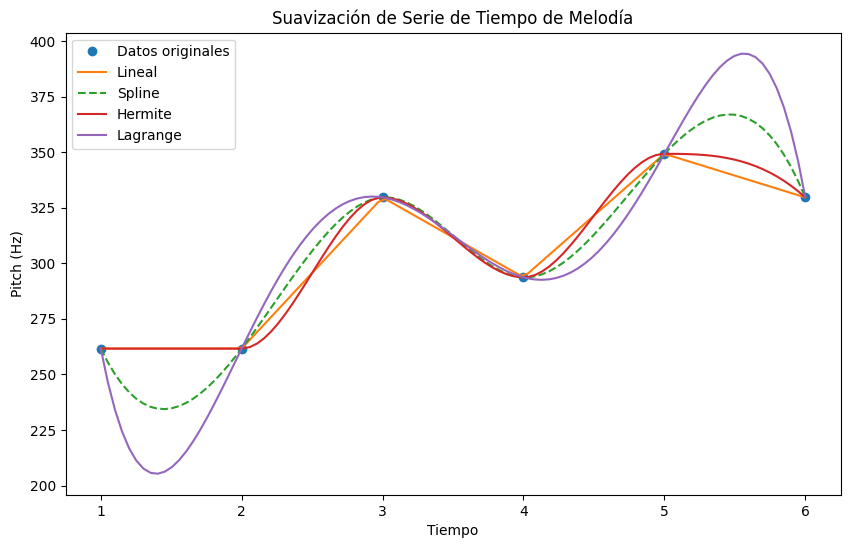

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from numpy.polynomial import Polynomial
from scipy.interpolate import lagrange
from scipy.interpolate import PchipInterpolator
from pykrige.ok import OrdinaryKriging


times = np.array([1, 2, 3, 4, 5, 6])
pitches = np.array([261.63, 261.63, 329.63, 293.66, 349.23, 329.63]) 

# Interpolacion Lineal
linear_interp = interp1d(times, pitches, kind='linear')

# Interpolacion Spline
spline_interp = CubicSpline(times, pitches)

# Interpolacion de Lagrange
lagrange_interp = lagrange(times, pitches)

#Interpolacion de Hermite
hermite_interp = PchipInterpolator(times, pitches)


# Generar puntos para graficar
fine_times = np.linspace(1, 6, 100)
linear_pitches = linear_interp(fine_times)
spline_pitches = spline_interp(fine_times)
lagrange_pitches = lagrange_interp(fine_times)
hermite_pitches = hermite_interp(fine_times)


# Graficar
plt.figure(figsize=(10, 6))
plt.plot(times, pitches, 'o', label='Datos originales')
plt.plot(fine_times, linear_pitches, '-', label='Lineal')
plt.plot(fine_times, spline_pitches, '--', label='Spline')
plt.plot(fine_times, hermite_pitches, '-', label='Hermite')
plt.plot(fine_times, lagrange_pitches, label='Lagrange')
plt.xlabel('Tiempo')
plt.ylabel('Pitch (Hz)')
plt.legend()
plt.title('Suavización de Serie de Tiempo de Melodía')
plt.show()


C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_9408\4076517723.py:52: RuntimeWarning: invalid value encountered in scalar divide
  e1=np.sum(e)/len(angulos)


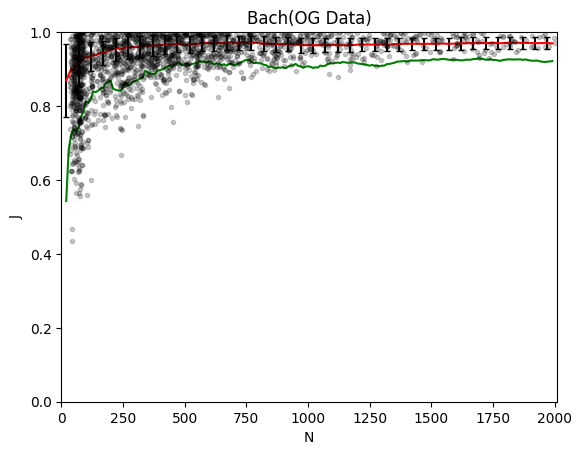

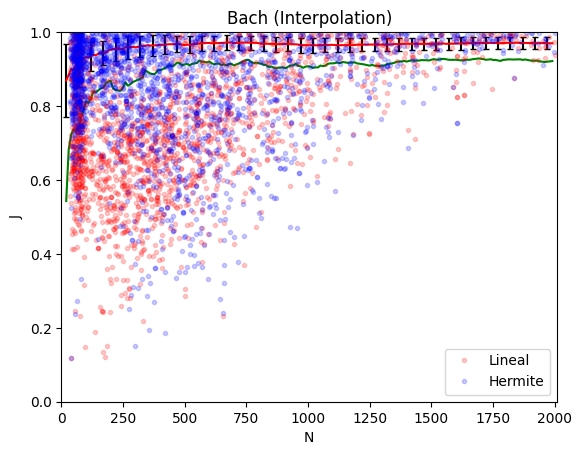

In [213]:
"""Compute individual"""
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')
composer = 'Bach' 
J_lineal_array = []
J_herm_array = []
for subject in composers[composer].values(): 

    data_lineal = interpolador(subject,'lineal', 10000)
    data_herm = interpolador(subject, 'herm', 10000)

    J_lineal = J_univariante(data_lineal, len(data_lineal)//2, True)
    J_lineal_array.append(J_lineal)
    J_herm = J_univariante(data_herm, len(data_herm)//2, True)
    J_herm_array.append(J_herm)
with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
num = datos_composers[composer]['Indice']
N = datos_composers[composer]['# Piezas']
plt.plot(Ns[num,:], J_composers[num,:], '.', color = 'black',  alpha = 0.2)
plt.title(composer + '(OG Data)')
plt.xlim(0, 2010)
plt.show()


with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
plt.plot( Ns[num,:N] , J_lineal_array, '.', color = 'red', alpha = 0.2, label = 'Lineal')
plt.plot( Ns[num,:N] , J_herm_array, '.', color = 'blue', alpha = 0.2, label = 'Hermite')
plt.title(composer + ' (Interpolation)')
plt.legend()
plt.xlim(0, 2010)
plt.show()

In [216]:
"""Compute everything"""

import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')

#################
for composer in composers:

    J_interp_lineal = []
    J_interp_hermite = []

    for subject in composers[composer].values():

        interp_lineal = interpolador(subject, 'lineal', 10000)

        interp_herm = interpolador(subject, 'herm', 10000)

        J_lineal = J_univariante(interp_lineal, len(interp_lineal)//2, True)
        J_herm = J_univariante(interp_herm, len(interp_herm)//2, True)

        J_interp_lineal.append(J_lineal)
        J_interp_hermite.append(J_herm)

    np.save('J_interpolacion_lineal_cortado/J_interp_' + str(composer) + '_lineal.npy', np.array(J_interp_lineal))
    np.save('J_interpolacion_hermite_cortado/J_interp_' + str(composer) + '_herm.npy', np.array(J_interp_hermite))

C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_9408\4076517723.py:52: RuntimeWarning: invalid value encountered in scalar divide
  e1=np.sum(e)/len(angulos)


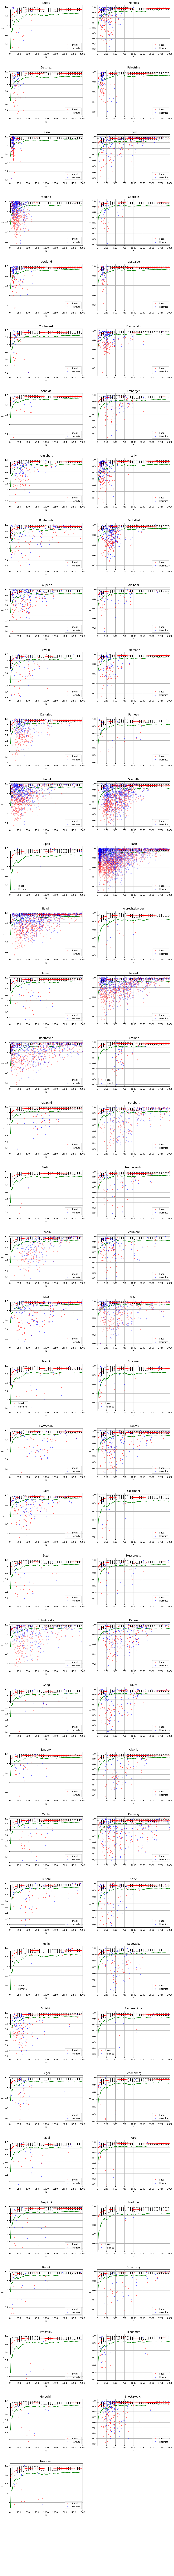

In [217]:
"""Plot everything"""

import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

Ns = np.load('Ns.npy')
Jotas = np.load('Jotas.npy')

x = range(20, 2000, 10)
J_mean = np.mean(Jotas, axis=0)
J_std = np.std(Jotas, axis = 0)

J_minus = np.min(Jotas, axis=0)


# Create a figure and subplots
fig, axs = plt.subplots(40, 2, figsize=(13, 210))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.2)

# Flatten the axs array to iterate over the subplots
axs = axs.flatten()

# Plot data on each subplot
for i,composer in enumerate(composers):
    #siempre
    axs[i].errorbar(x = x[::5], y = J_mean[::5], yerr= J_std[::5], fmt='none', ecolor = 'black', capsize=2)
    axs[i].plot(x, J_mean, color = 'red')
    axs[i].set_xlim(0, 2010)
    axs[i].set_xlabel('N')
    axs[i].set_ylabel('J') 
    axs[i].plot(x, J_minus, 'green')
    axs[i].grid()
    #for in
    J_interp_lineal = np.load('J_interpolacion_lineal_cortado/J_interp_' + str(composer) + '_lineal.npy')
    J_interp_hermite = np.load('J_interpolacion_hermite_cortado/J_interp_' + str(composer) + '_herm.npy')
    axs[i].set_title(composer)
    # axs[i].plot(Ns[i,:], Js[i,:], '.',color = 'blue')
    if len(J_interp_lineal) <= 200:
        alpha = 0.5
    elif len(J_interp_lineal) > 200 and len(J_interp_lineal) <= 800:
        alpha = 0.3
    else:
        alpha = 0.2 
    axs[i].plot( Ns[i,:datos_composers[composer]['# Piezas'] ], J_interp_lineal, '.', color = 'red', alpha = alpha, label='lineal')
    axs[i].plot( Ns[i,:datos_composers[composer]['# Piezas']], J_interp_hermite, '.', color = 'blue', alpha = alpha, label='Hermite')
    axs[i].set_xlim(0, 2010)
    axs[i].legend()

# Hide any empty subplots
for j in range(77, 80):
    axs[j].axis('off')

plt.show()

[0.79896029 0.95164578 0.90088488 0.91278875 0.57402896 0.99982412
 0.79065109 0.89643609 0.92431692]


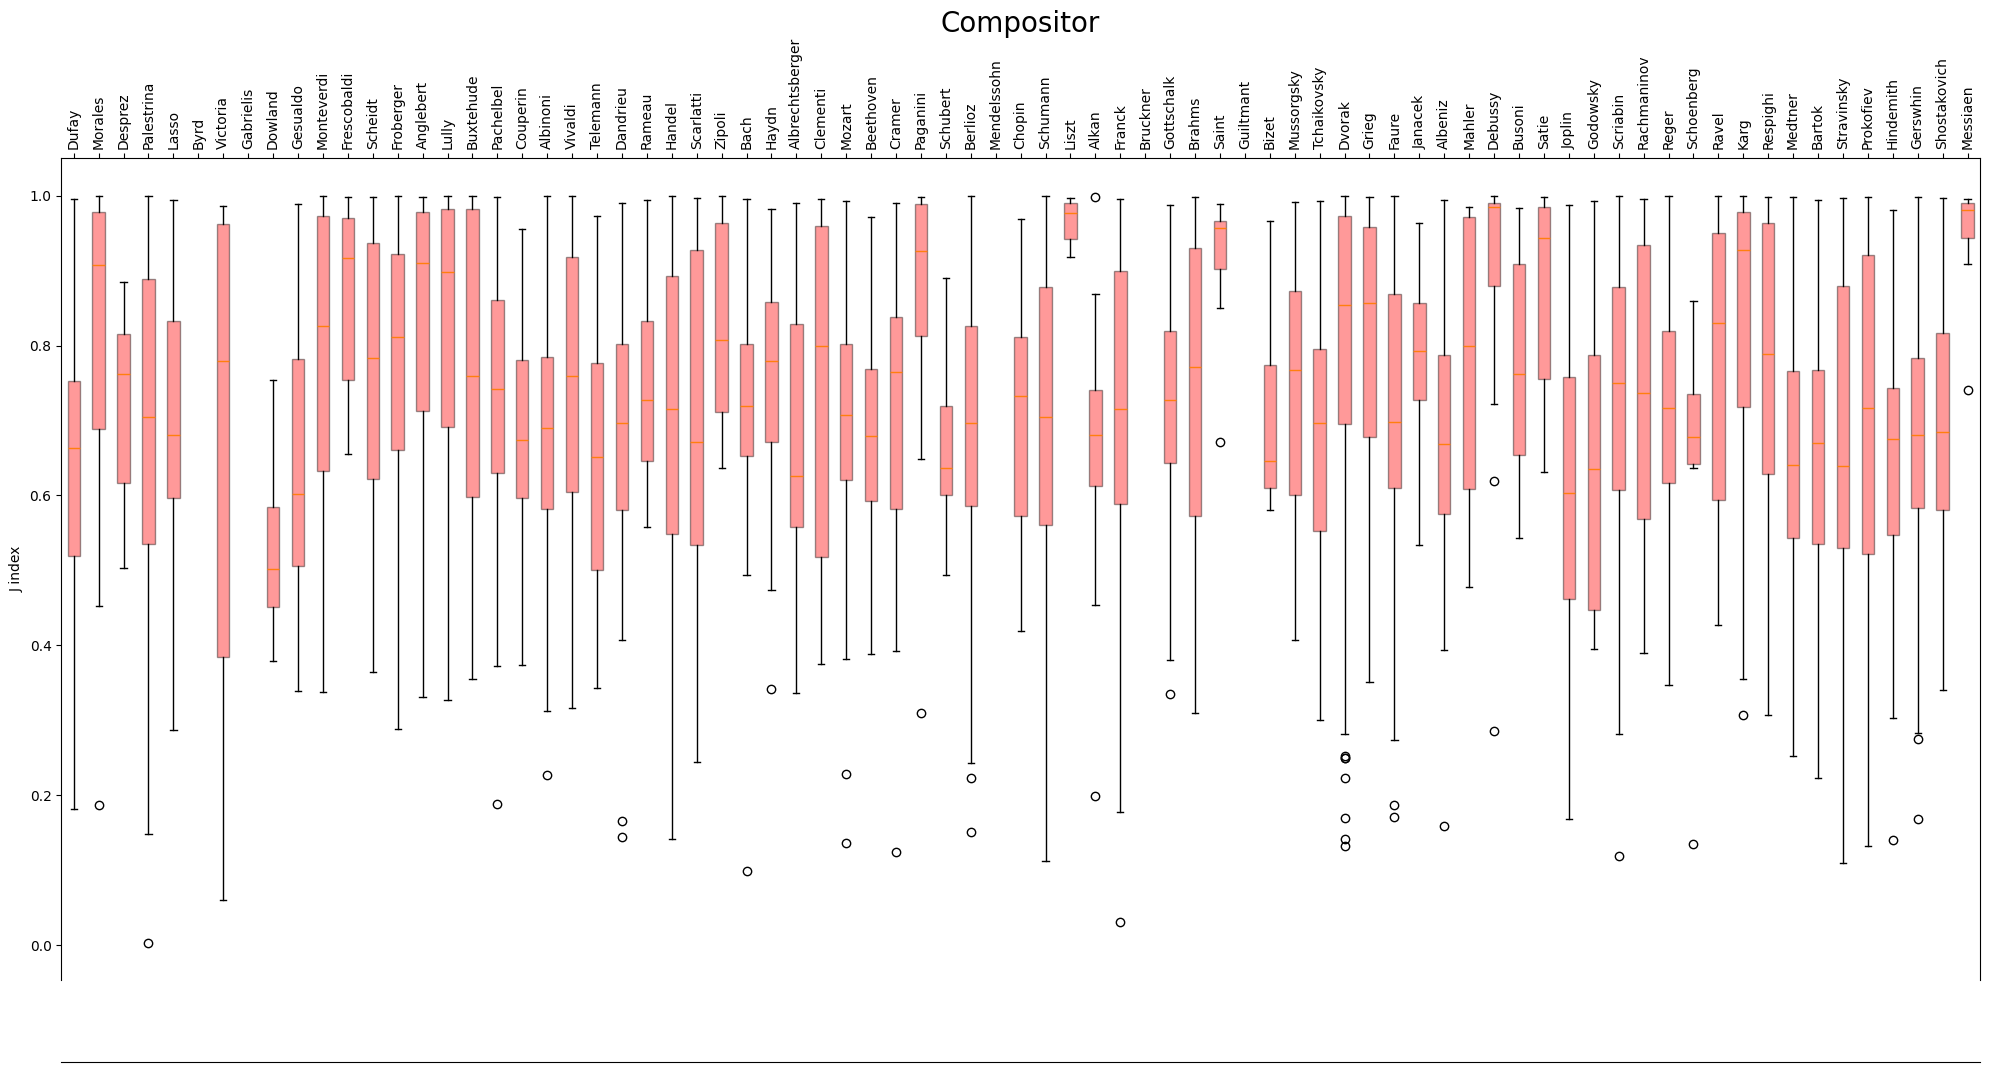

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import os

Ns = np.load('Ns.npy')

carpeta1 = 'J_interpolacion_lineal_cortado' 
archivos_en_carpeta1 = os.listdir(carpeta1)

carpeta2 = 'J_interpolacion_hermite_cortado' 
archivos_en_carpeta2 = os.listdir(carpeta2)

data1 = [np.load(os.path.join(carpeta1, array)) for array in archivos_en_carpeta1]
data2 = [np.load(os.path.join(carpeta2, array)) for array in archivos_en_carpeta2]

fig, ax = plt.subplots(figsize=(20, 10))
box1 = ax.boxplot(data1, patch_artist=True)
# box2 = ax.boxplot(data2, patch_artist=True)
print(np.load('J_interpolacion_hermite_cortado\J_interp_Messiaen_herm.npy'))

for patch in box2['boxes']:
    patch.set_facecolor('blue')
    patch.set_alpha(0.4) 

for patch in box1['boxes']:
    patch.set_facecolor('red')
    patch.set_alpha(0.4) 

ax.set_xlabel(f'Compositor', fontsize=20)
ax.set_ylabel('J index')
ax.set_xticks(np.arange(1, 78))  
ax.set_xticklabels([f'{composer}' for i, composer in enumerate(datos_composers.keys())], rotation=90)  # Rotar las etiquetas del eje x

ax.xaxis.set_label_position('top')  # Movemos la etiqueta del eje x
ax.xaxis.tick_top()  # Movemos los ticks del eje x a la parte superior
ax.spines['top'].set_position(('axes', 1.0))  # Movemos la espina superior al tope de la figura
ax.spines['bottom'].set_position(('axes', -0.1))  # Ocultamos la espina inferior

plt.setp(ax.get_xticklabels(), rotation=90, ha='center')


plt.tight_layout()
plt.show()



C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_6036\3719487226.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(birth_days, rotation=90)


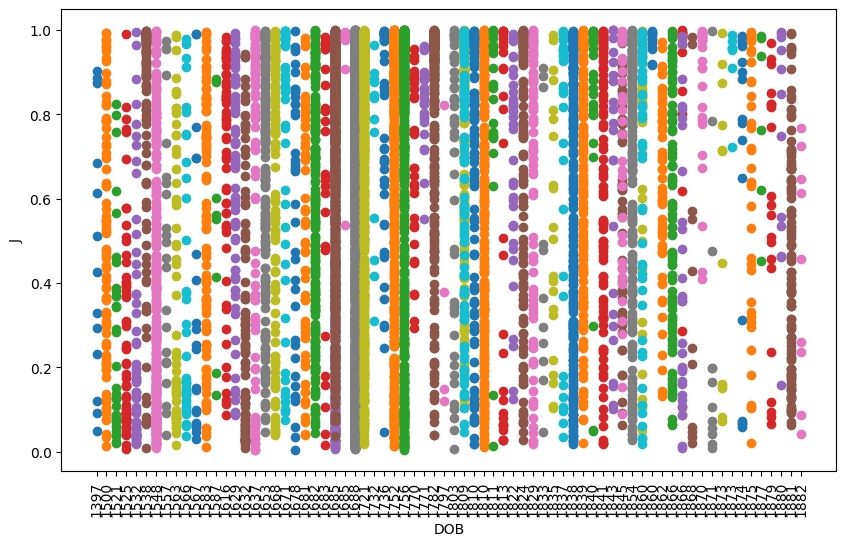

In [126]:
birth_days = np.array([datos_composers[composer]['Birth_year'] for composer in datos_composers.keys()])


J_interp_lineal = [np.load('J_interpolacion_lineal/J_interp_' + str(composer) + '_lineal.npy') for composer in datos_composers.keys()]
J_interp_hermite = [np.load('J_interpolacion_hermite/J_interp_' + str(composer) + '_herm.npy') for composer in datos_composers.keys()]

fig, ax = plt.subplots(figsize=(10, 6))

for i, composer in enumerate(datos_composers.keys()):
    ax.plot([birth_days[i]] * len(J_interp_lineal[i]), J_interp_lineal[i], 'o', label=f'{composer} Lineal')

ax.set_xlabel('DOB')
ax.set_ylabel('J')

ax.set_xticklabels(birth_days, rotation=90)

plt.show()

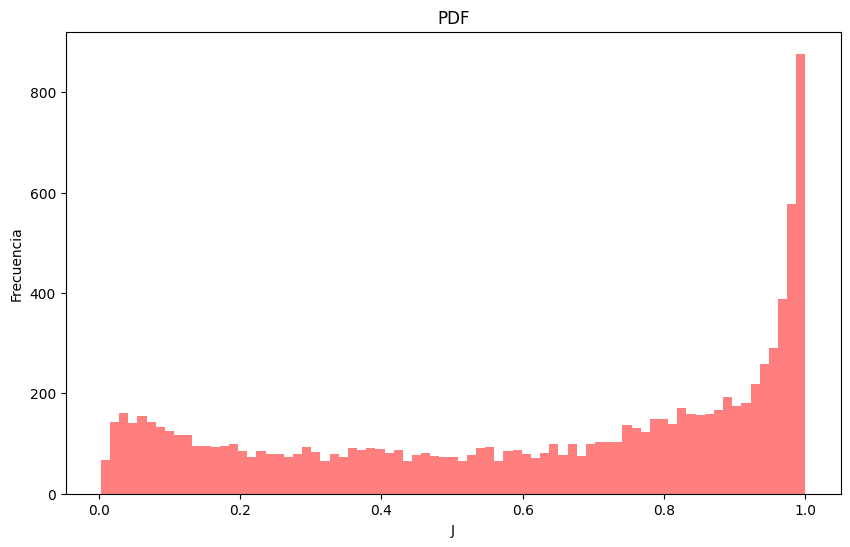

In [125]:
data1_flat = np.concatenate(data1)

pdf, bins = np.histogram(data1_flat, bins=77)

bins_center = (bins[:-1] + bins[1:]) / 2

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(bins_center, pdf, width=bins[1] - bins[0], alpha=0.5, color='red')

ax.set_xlabel('J')
ax.set_ylabel('Frecuencia')
ax.set_title('PDF')